#Image classify of food

In [1]:
import google.colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

In [3]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#impport data

In [4]:
DATASET_ROOT = "/content/drive/MyDrive/Pytorch/Image_classification"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

NUM_CLASSES = 3        # You said 3 categories
IMG_SIZE = 128         # Can change to 224 if needed

#data augmentation

In [5]:
# ==============================
# Data Augmentation
# ==============================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#Dataset DataLoader

Use this when images aren't in image form PIL

```
from PIL import Image
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to (28, 28)
    image = self.features[index].reshape(28,28)

    # change datatype to np.uint8
    image = image.astype(np.uint8)

    # change black&white to color -> (H,W,C) -> (C,H,W)
    image = np.stack([image]*3, axis=-1)
    #now it is (C,H,W) -> (H,W,C)

    # convert array to PIL image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)

train_dataset = CustomDataset(root=TRAIN_DIR, transform=custom_transform)
test_dataset = CustomDataset(root=TEST_DIR, transform = custom_transform)
```



In [7]:
# Use augmentations in training data
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=test_transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size = 32 , shuffle=True , pin_memory= True)

test_loader = DataLoader(test_dataset, batch_size = 32 , shuffle=False, pin_memory= True)

In [9]:
print("Class mapping:", train_dataset.class_to_idx)

Class mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}


#Model

In [10]:
# ==============================
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        #  Dynamic feature size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
            dummy = self.features(dummy)
            feature_dim = dummy.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = MyCNN().to(device)

#Train

In [11]:
epochs = 50
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      weight_decay=1e-4)


In [13]:
# Training Loop
# ==============================
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/50] - Loss: 1.2829
Epoch [2/50] - Loss: 1.9564
Epoch [3/50] - Loss: 1.2476
Epoch [4/50] - Loss: 1.3376
Epoch [5/50] - Loss: 1.2150
Epoch [6/50] - Loss: 1.2214
Epoch [7/50] - Loss: 1.1521
Epoch [8/50] - Loss: 1.1476
Epoch [9/50] - Loss: 1.1319
Epoch [10/50] - Loss: 1.0683
Epoch [11/50] - Loss: 1.1222
Epoch [12/50] - Loss: 1.0956
Epoch [13/50] - Loss: 1.1289
Epoch [14/50] - Loss: 1.1280
Epoch [15/50] - Loss: 1.0881
Epoch [16/50] - Loss: 1.0751
Epoch [17/50] - Loss: 1.0890
Epoch [18/50] - Loss: 1.0742
Epoch [19/50] - Loss: 1.4446
Epoch [20/50] - Loss: 1.1688
Epoch [21/50] - Loss: 1.0824
Epoch [22/50] - Loss: 1.0782
Epoch [23/50] - Loss: 1.0614
Epoch [24/50] - Loss: 1.0717
Epoch [25/50] - Loss: 1.0523
Epoch [26/50] - Loss: 0.9806
Epoch [27/50] - Loss: 1.0420
Epoch [28/50] - Loss: 1.0241
Epoch [29/50] - Loss: 0.9603
Epoch [30/50] - Loss: 1.0925
Epoch [31/50] - Loss: 0.9975
Epoch [32/50] - Loss: 1.0153
Epoch [33/50] - Loss: 1.0541
Epoch [34/50] - Loss: 1.0102
Epoch [35/50] - Loss: 1

In [15]:
from sklearn.metrics import accuracy_score

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 44.00%


#Confusion Matrix

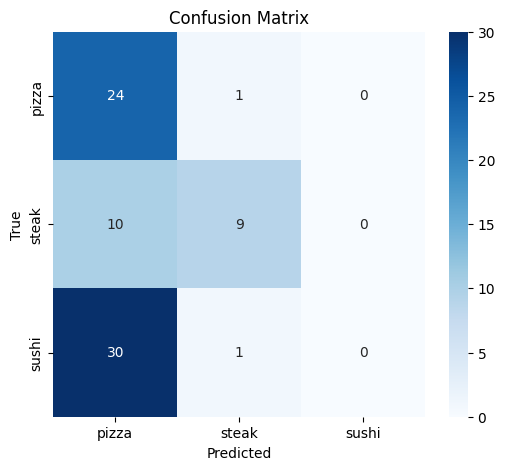

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
